# Predicting Delivery Performance: Data-Driven Approach to Supply Chain Optimization

## Data Preprocessing

In [904]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

In [905]:
# Reads CSV file and assign variable
df = pd.read_csv("DataCoSupplyChainDataset.csv", encoding='ISO-8859-1')

In [906]:
# Print the first 5 rows
df.head()

,Type,Days_for_shipping_(real),Days_for_shipment_(scheduled),Benefit_per_order,Sales_per_customer,Delivery_Status,Late_delivery_risk,Category_Id,Category_Name,Customer_City,...,Order_Zipcode,Product_Card_Id,Product_Category_Id,Product_Description,Product_Image,Product_Name,Product_Price,Product_Status,shipping_date_(DateOrders),Shipping_Mode
0,DEBIT,3,4,91.25,314.64,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018,Standard Class
1,TRANSFER,5,4,-249.09,311.36,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018,Standard Class
2,CASH,4,4,-247.78,309.72,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018,Standard Class
3,DEBIT,3,4,22.86,304.81,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018,Standard Class
4,PAYMENT,2,4,134.21,298.25,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018,Standard Class


In [907]:
# Show types of values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days_for_shipping_(real)       180519 non-null  int64  
 2   Days_for_shipment_(scheduled)  180519 non-null  int64  
 3   Benefit_per_order              180519 non-null  float64
 4   Sales_per_customer             180519 non-null  float64
 5   Delivery_Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category_Id                    180519 non-null  int64  
 8   Category_Name                  180519 non-null  object 
 9   Customer_City                  180519 non-null  object 
 10  Customer_Country               180519 non-null  object 
 11  Customer_Email                 180519 non-null  object 
 12  Customer_Fname                

In [908]:
# Check for missing values
missing_values = df.isnull().sum()
columns_missing_values = missing_values[missing_values > 0]
print("Columns values for column:")
print(columns_missing_values)

Columns values for column:
Customer_Lname              8
Customer_Zipcode            3
Order_Zipcode          155676
Product_Description    180519
dtype: int64


In [909]:
# Remove rows with missin values under the customer zip code column
df = df.dropna(subset=['Customer_Zipcode'])

"""3 out of 180,000 rows will little to no impact on analysis. Also, using machine learning to fill that zip code, 
    would mean analying customer data in depth and could raise privacy concerns
"""

'3 out of 180,000 rows will little to no impact on analysis. Also, using machine learning to fill that zip code, \n    would mean analying customer data in depth and could raise privacy concerns\n'

In [910]:
df['Customer_Zipcode'] = df['Customer_Zipcode'].astype(int)

In [911]:
# Drop columns
columns_to_drop = ['Customer_City', 'Customer_Country', 'Customer_Email', 'Customer_Fname', 'Customer_Id', 'Customer_Lname', 'Customer_Password', 'Customer_State', 'Customer_Street', 'Product_Description', 
                   'Order_Zipcode', 'Product_Image', 'Product_Name', 'Order_Id', 'Order_Region', 'Product_Status', 'Market', 'Order_Profit_Per_Order', 'Order_Item_Total', 'Department_Id', 'Order_Item_Cardprod_Id', 
                   'Product_Category_Id', 'Product_Card_Id', 'Order_Customer_Id', 'Product_Status']

df.drop(columns=columns_to_drop, inplace=True)

"""Dropping customer information columns since they are needed and helps with privacy concerns. Removing other columns like product image, description, order 
        id and zipcode since they don't provide necessary information
"""

"Dropping customer information columns since they are needed and helps with privacy concerns. Removing other columns like product image, description, order \n        id and zipcode since they don't provide necessary information\n"

In [912]:
df.describe()

,Days_for_shipping_(real),Days_for_shipment_(scheduled),Benefit_per_order,Sales_per_customer,Late_delivery_risk,Category_Id,Customer_Zipcode,Latitude,Longitude,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Id,Order_Item_Product_Price,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Product_Price
count,180516.00,180516.00,180516.00,180516.00,180516.00,180516.00,180516.00,180516.00,180516.00,180516.00,180516.00,180516.00,180516.00,180516.00,180516.00,180516.00,180516.00
mean,3.50,2.93,21.97,183.11,0.55,31.85,35921.13,29.72,-84.92,20.66,0.10,90258.59,141.23,0.12,2.13,203.77,141.23
std,1.62,1.37,104.43,120.04,0.50,15.64,37542.46,9.81,21.43,21.80,0.07,52110.78,139.73,0.47,1.45,132.27,139.73
min,0.00,0.00,-4274.98,7.49,0.00,2.00,603.00,-33.94,-158.03,0.00,0.00,1.00,9.99,-2.75,1.00,9.99,9.99
25%,2.00,2.00,7.00,104.38,0.00,18.00,725.00,18.27,-98.45,5.40,0.04,45129.75,50.00,0.08,1.00,119.98,50.00
50%,3.00,4.00,31.52,163.99,1.00,29.00,19380.00,33.14,-76.84,14.00,0.10,90258.50,59.99,0.27,1.00,199.92,59.99
75%,5.00,4.00,64.80,247.40,1.00,45.00,78207.00,39.28,-66.37,29.99,0.16,135387.25,199.99,0.36,3.00,299.95,199.99
max,6.00,4.00,911.80,1939.99,1.00,76.00,99205.00,48.78,115.26,500.00,0.25,180519.00,1999.99,0.50,5.00,1999.99,1999.99


- Benefit_per_order: The minimum value for the benefit per order is negative(-4274.98), which suggests that some orders incurred a loss. This could be an area for concern for the business and may warrant further investigation into the reasons behind the negative benefits.
- Late_delivery_risk: The late delivery risk column has a mean value of approximately .55, indicating that on average, about 55% of the orders are at risk of being delivered late. This suggests a significant proportion of orders face potential delays, which could impact customer satisfaction and business reputation.
- Days_for_shipping_(real) and Days_for_shipment(scheduled): The mean values for these columns indicate that, on average, the actual shipping time is slightly higher(approximately 3.5 days) than the scheduled shipping time(approxiamtely 2.93 days). This suggests that orders tend to take slightly longer to ship than initially planned.
- Sales_per_customer: The range of sales per customer varies widely, from $7.49 to $1939.99, with a mean of approximately $183.11. This indicares variability in customer spending behavior, with some customer making small purchases while others make larger ones.


In [913]:
# Change dtype to date columns
date_columns = ['order_date_(DateOrders)', 'shipping_date_(DateOrders)']
df[date_columns[0]] = pd.to_datetime(df[date_columns[0]])
df[date_columns[1]] = pd.to_datetime(df[date_columns[1]])

In [914]:
# Split the columns into numerical and categorical columns
numerical_columns = df.select_dtypes(include=['float', 'int']).columns.tolist()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print("Numerical Features: ", numerical_columns)
print()
print("Categorical Features: ", categorical_columns)

Numerical Features:  ['Days_for_shipping_(real)', 'Days_for_shipment_(scheduled)', 'Benefit_per_order', 'Sales_per_customer', 'Late_delivery_risk', 'Category_Id', 'Customer_Zipcode', 'Latitude', 'Longitude', 'Order_Item_Discount', 'Order_Item_Discount_Rate', 'Order_Item_Id', 'Order_Item_Product_Price', 'Order_Item_Profit_Ratio', 'Order_Item_Quantity', 'Sales', 'Product_Price']

Categorical Features:  ['Type', 'Delivery_Status', 'Category_Name', 'Customer_Segment', 'Department_Name', 'Order_City', 'Order_Country', 'Order_State', 'Order_Status', 'Shipping_Mode']


In [915]:
# Count unique values in each column and then calcualtes the shape
df[categorical_columns].apply(lambda x: x.value_counts().shape[0]).to_frame().T

,Type,Delivery_Status,Category_Name,Customer_Segment,Department_Name,Order_City,Order_Country,Order_State,Order_Status,Shipping_Mode
0,4,4,50,3,11,3596,164,1089,9,4


### Crosstabs

In [916]:
def cross_tab(dataframe, col, columns_list):
    new = []
    for c in columns_list:
        # Crosstab to count occurrences of late delivery risk
        crosstab_result = pd.crosstab(dataframe[col], dataframe[c], margins=True, margins_name='Total')
        # Compute the proportion of late deliveries
        proportion_late_delivery = crosstab_result[1] / crosstab_result['Total']
        # Append the proportion column to the crosstab result
        crosstab_result['Proportion Late Delivery'] = proportion_late_delivery
        # Sort the DataFrame by the proportion column in descending order
        crosstab_result.sort_values(by='Proportion Late Delivery', ascending=False, inplace=True)
        # Append the result to the list
        new.append(crosstab_result)
    # Concatenate the results horizontally
    new_df = pd.concat(new, axis=1, keys=columns_list)
    return new_df

cross_tab(df, 'Category_Name', ['Late_delivery_risk'])

Late_delivery_risk                 \
Late_delivery_risk                    0      1   Total   
Category_Name                                            
Golf Bags & Carts                    19     42      61   
Lacrosse                            137    206     343   
Pet Supplies                        202    290     492   
Cameras                             248    344     592   
Strength Training                    47     64     111   
As Seen on  TV!                      29     39      68   
Music                               186    248     434   
Accessories                         766   1014    1780   
Fitness Accessories                 133    176     309   
Books                               176    229     405   
Women's Clothing                    283    367     650   
Boxing & MMA                        185    238     423   
Golf Gloves                         468    602    1070   
Hunting & Shooting                  193    247     440   
Electronics                        1386   1770    3156   
Crafts                              213    271     484   
Health and Beauty                   160    202     362   
Tennis & Racquet                    145    183     328   
Garden                              214    270     484   
Trade-In                            432    542     974   
Golf Shoes                          233    291     524   
Sporting Goods                      159    198     357   
Girls' Apparel                      537    664    1201   
Basketball                           30     37      67   
Baseball & Softball                 283    349     632   
Shop By Sport                      4926   6058   10984   
Consumer Electronics                193    237     430   
Toys                                238    291     529   
Cleats                            11055  13496   24551   
Fishing                            7809   9516   17325   
Total                             81540  98976  180516   
Water Sports                       7023   8517   15540   
Indoor/Outdoor Games               8733  10565   19298   
Golf Balls                          670    805    1475   
Women's Apparel                    9559  11476   21035   
Camping & Hiking                   6242   7487   13729   
Cardio Equipment                   5682   6805   12487   
Men's Footwear                    10125  12121   22246   
Video Games                         382    455     837   
Soccer                               63     75     138   
Men's Clothing                       95    113     208   
DVDs                                224    259     483   
Women's Golf Clubs                   84     97     181   
Hockey                              285    329     614   
Children's Clothing                 303    348     651   
Kids' Golf Clubs                    179    205     384   
Baby                                 98    109     207   
CDs                                 130    141     271   
Golf Apparel                        212    229     441   
Computers                           218    224     442   
Men's Golf Clubs                    148    135     283   

                                               
Late_delivery_risk   Proportion Late Delivery  
Category_Name                                  
Golf Bags & Carts                        0.69  
Lacrosse                                 0.60  
Pet Supplies                             0.59  
Cameras                                  0.58  
Strength Training                        0.58  
As Seen on  TV!                          0.57  
Music                                    0.57  
Accessories                              0.57  
Fitness Accessories                      0.57  
Books                                    0.57  
Women's Clothing                         0.56  
Boxing & MMA                             0.56  
Golf Gloves                              0.56  
Hunting & Shooting                       0.56  
Electronics                              0.56  
Crafts                  

#### Visual Cues from Crosstab:
- Overall Late Delivery Risk: The total number of late deliveries is 98,976 out of 180,516 total deliveries recorded in the dataset. This indicates that approximately 54.8% of deliveries are at risk of being late.
- Category with Highest Late Delivery Risk: "Golf Bags & Carts" has the highest late delivery risk proportion at 68.85%. This category exhibits a significantly higher risk compared to others.
- Variability Across Categories: There is notable variability in late delivery risk across different categories. Some categories, like "Golf Bags & Carts" and "Lacrosse," have high proportions of late deliveries, while others, such as "Men's Golf Clubs" and "Computers," have relatively low proportions.
- Popular Categories with High Late Delivery Risk: Categories like "Accessories" and "Fitness Accessories" have high proportions of late deliveries despite their popularity, indicating potential areas for improvement in delivery logistics.
- Popular Categories with Low Late Delivery Risk: Although popular, categories like "Men's Golf Clubs" and "Computers" exhibit relatively low proportions of late deliveries, suggesting efficient delivery management within these segments.

In [917]:
def cross_tab_with_ratios(dataframe, col, columns_list):
    new = []
    for c in columns_list:
        new.append(pd.crosstab(dataframe[col], dataframe[c], margins=True, margins_name='Total'))
    
    new_df = pd.concat(new, axis=1, keys=columns_list)
    
    # Calculate ratios
    new_df[('Delivery_Status', 'Late_delivery_ratio')] = new_df[('Delivery_Status', 'Late delivery')] / new_df[('Delivery_Status', 'Total')]
    new_df[('Delivery_Status', 'Shipping_canceled_ratio')] = new_df[('Delivery_Status', 'Shipping canceled')] / new_df[('Delivery_Status', 'Total')]
    new_df[('Delivery_Status', 'Shipping_on_time_ratio')] = new_df[('Delivery_Status', 'Shipping on time')] / new_df[('Delivery_Status', 'Total')]
    
    # Sort by Shipping_on_time_ratio in descending order
    new_df = new_df.sort_values(by=('Delivery_Status', 'Shipping_on_time_ratio'), ascending=False)
    
    return new_df

In [918]:
cross_tab_with_ratios(df, 'Category_Name', ['Delivery_Status'])

Delivery_Status                                  \
Delivery_Status      Advance shipping Late delivery Shipping canceled   
Category_Name                                                           
Soccer                             28            75                 2   
Strength Training                  22            64                 2   
CDs                                67           141                 8   
Tennis & Racquet                   65           183                14   
Men's Golf Clubs                   83           135                 9   
Baby                               49           109                 9   
Golf Apparel                      116           229                12   
Computers                         117           224                17   
Boxing & MMA                       84           238                21   
Video Games                       190           455                34   
Books                              87           229                14   
Baseball & Softball               141           349                25   
Pet Supplies                       91           290                20   
Camping & Hiking                 3147          7487               572   
Women's Clothing                  145           367                19   
Men's Footwear                   5104         12121               983   
Water Sports                     3547          8517               660   
Cleats                           5570         13496              1037   
Indoor/Outdoor Games             4451         10565               828   
Women's Apparel                  4886         11476               919   
Total                           41592         98976              7754   
Children's Clothing               157           348                30   
Cardio Equipment                 2921          6805               539   
As Seen on  TV!                    15            39                 2   
DVDs                              115           259                24   
Toys                              123           291                22   
Fishing                          4034          9516               730   
Shop By Sport                    2536          6058               469   
Golf Gloves                       240           602                41   
Kids' Golf Clubs                   84           205                28   
Golf Shoes                        120           291                22   
Hunting & Shooting                101           247                16   
Crafts                            104           271                26   
Health and Beauty                  83           202                16   
Music                              97           248                17   
Garden                            116           270                18   
Electronics                       733          1770               132   
Fitness Accessories                69           176                13   
Hockey                            158           329                26   
Men's Clothing                     51           113                10   
Golf Balls                        357           805                72   
Consumer Electronics              101           237                22   
Girls' Apparel                    284           664                64   
Trade-In                          232           542                48   
Accessories                       406          1014                83   
Cameras                           126           344                30   
Sporting Goods                     83           198                21   
Women's Golf Clubs                 47            97                11   
Lacrosse                           75           206                14   
Golf Bags & Carts                  12            42                 0   
Basketball                         22            37                 3   

                                                                   \
Delivery_S

#### Visual Cues from Crosstab:
- Late Delivery Ratio Analysis:
Categories with the highest late delivery ratios include Lacrosse (60.1%), Golf Bags & Carts (68.9%), and As Seen on TV! (57.4%).
Categories such as Soccer (54.3%), Strength Training (57.7%), and CDs (52.0%) have relatively lower late delivery ratios. They exhibit better performance in meeting delivery timelines.
Overall, the average late delivery ratio across all categories is 54.8%, indicating that more than half of the deliveries experience delays.
- Shipping Canceled Ratio Analysis:
Categories with higher shipping canceled ratios, such as Kids' Golf Clubs (7.3%), DVDs (4.97%), and Books (3.46%), suggest issues with order cancellations or unavailability of products.
On the other hand, categories like Golf Bags & Carts (0%), Health and Beauty (4.42%), and Music (3.92%) experience fewer instances of canceled shipments.
The average shipping canceled ratio across all categories is 4.30%.
- Shipping on Time Ratio Analysis:
Categories with the highest shipping on time ratios include Soccer (23.9%), Strength Training (20.7%), and CDs (20.3%).
Categories like Golf Bags & Carts (11.48%), Basketball (7.46%), and Men's Clothing (16.35%) have lower shipping on time ratios, indicating challenges in meeting delivery timelines consistently.
The average shipping on time ratio across all categories is 17.83%.

In [919]:
def cross_tab(dataframe, col, columns_list):
    new = []
    for c in columns_list:
        # Crosstab to count occurrences
        crosstab_result = pd.crosstab(dataframe[col], dataframe[c], margins=False)
        # Sum the rows to get the total count
        crosstab_result['Total'] = crosstab_result.sum(axis=1)
        # Sort the DataFrame by the total column in descending order
        crosstab_result_sorted = crosstab_result.sort_values(by='Total', ascending=False)
        # Append the result to the list
        new.append(crosstab_result_sorted)
    # Concatenate the results horizontally
    new_df = pd.concat(new, axis=1, keys=columns_list)
    return new_df

In [920]:
cross_tab(df, 'Category_Name', ['Customer_Segment'])

Customer_Segment                             
Customer_Segment             Consumer Corporate Home Office  Total
Category_Name                                                     
Cleats                          12700      7347        4504  24551
Men's Footwear                  11472      6817        3957  22246
Women's Apparel                 10864      6418        3753  21035
Indoor/Outdoor Games             9959      5974        3365  19298
Fishing                          9023      5237        3065  17325
Water Sports                     8111      4677        2752  15540
Camping & Hiking                 7043      4213        2473  13729
Cardio Equipment                 6513      3786        2188  12487
Shop By Sport                    5766      3267        1951  10984
Electronics                      1686       929         541   3156
Accessories                       901       537         342   1780
Golf Balls                        786       417         272   1475
Girls' Apparel                    604       384         213   1201
Golf Gloves                       540       338         192   1070
Trade-In                          468       327         179    974
Video Games                       455       206         176    837
Children's Clothing               332       211         108    651
Women's Clothing                  328       194         128    650
Baseball & Softball               337       188         107    632
Hockey                            327       185         102    614
Cameras                           321       158         113    592
Toys                              265       143         121    529
Golf Shoes                        275       160          89    524
Pet Supplies                      241       161          90    492
Crafts                            276       140          68    484
Garden                            261       160          63    484
DVDs                              261       154          68    483
Computers                         233       137          72    442
Golf Apparel                      233       133          75    441
Hunting & Shooting                234       129          77    440
Music                             183       127         124    434
Consumer Electronics              227       135          68    430
Boxing & MMA                      219       125          79    423
Books                             179       129          97    405
Kids' Golf Clubs                  198       114          72    384
Health and Beauty                 190       117          55    362
Sporting Goods                    164       136          57    357
Lacrosse                          182        98          63    343
Tennis & Racquet                  165       112          51    328
Fitness Accessories               151        90          68    309
Men's Golf Clubs                  138        89          56    283
CDs                               150        83          38    271
Men's Clothing                    111        66          31    208
Baby                              107        72          28    207
Women's Golf Clubs                 95        51          35    181
Soccer                             75        37          26    138
Strength Training                  58        23          30    111
As Seen on  TV!                    31        22          15     68
Basketball                         32        19          16     67
Golf Bags & Carts                  32        16          13     61

#### - Visual Cues for Crosstab
- Top Categories by Total Sales:
Cleats, Men's Footwear, Women's Apparel, and Indoor/Outdoor Games are the top four categories in terms of total sales across all customer segments.
- Segment-Specific Preferences:
For Consumer, Corporate, and Home Office, Cleats, Men's Apparel, Women's Apparel, Indoor/Outdoor games, and Fishing are the top 5 categories across all segments.
- Comparative Sales Analysis:
Cleats and Men's Footwear consistently have high sales across all customer segments, indicating their popularity.
Women's Apparel and Indoor/Outdoor Games also maintain strong sales performance across all segments.
- Low Sales Categories:
Categories like Golf Bags & Carts, Basketball, and As Seen on TV! have relatively low sales across all customer segments.


## Exploratory Data Analysis (EDA)

### Correlation Analysis

In [921]:
# Calculate pearson and spearman correlation on the numerical columns
pearson_corr = df[numerical_columns].corr().round(2)
spearman_corr = df[numerical_columns].corr(method='spearman').round(2)

print("Pearson Correlation:")
print(pearson_corr)

print("\nSpearman Correlation:")
print(spearman_corr)


Pearson Correlation:
                               Days_for_shipping_(real)  \
Days_for_shipping_(real)                           1.00   
Days_for_shipment_(scheduled)                      0.52   
Benefit_per_order                                 -0.01   
Sales_per_customer                                 0.00   
Late_delivery_risk                                 0.40   
Category_Id                                       -0.00   
Customer_Zipcode                                   0.00   
Latitude                                          -0.00   
Longitude                                          0.00   
Order_Item_Discount                                0.00   
Order_Item_Discount_Rate                           0.00   
Order_Item_Id                                     -0.00   
Order_Item_Product_Price                           0.00   
Order_Item_Profit_Ratio                           -0.00   
Order_Item_Quantity                               -0.00   
Sales                              

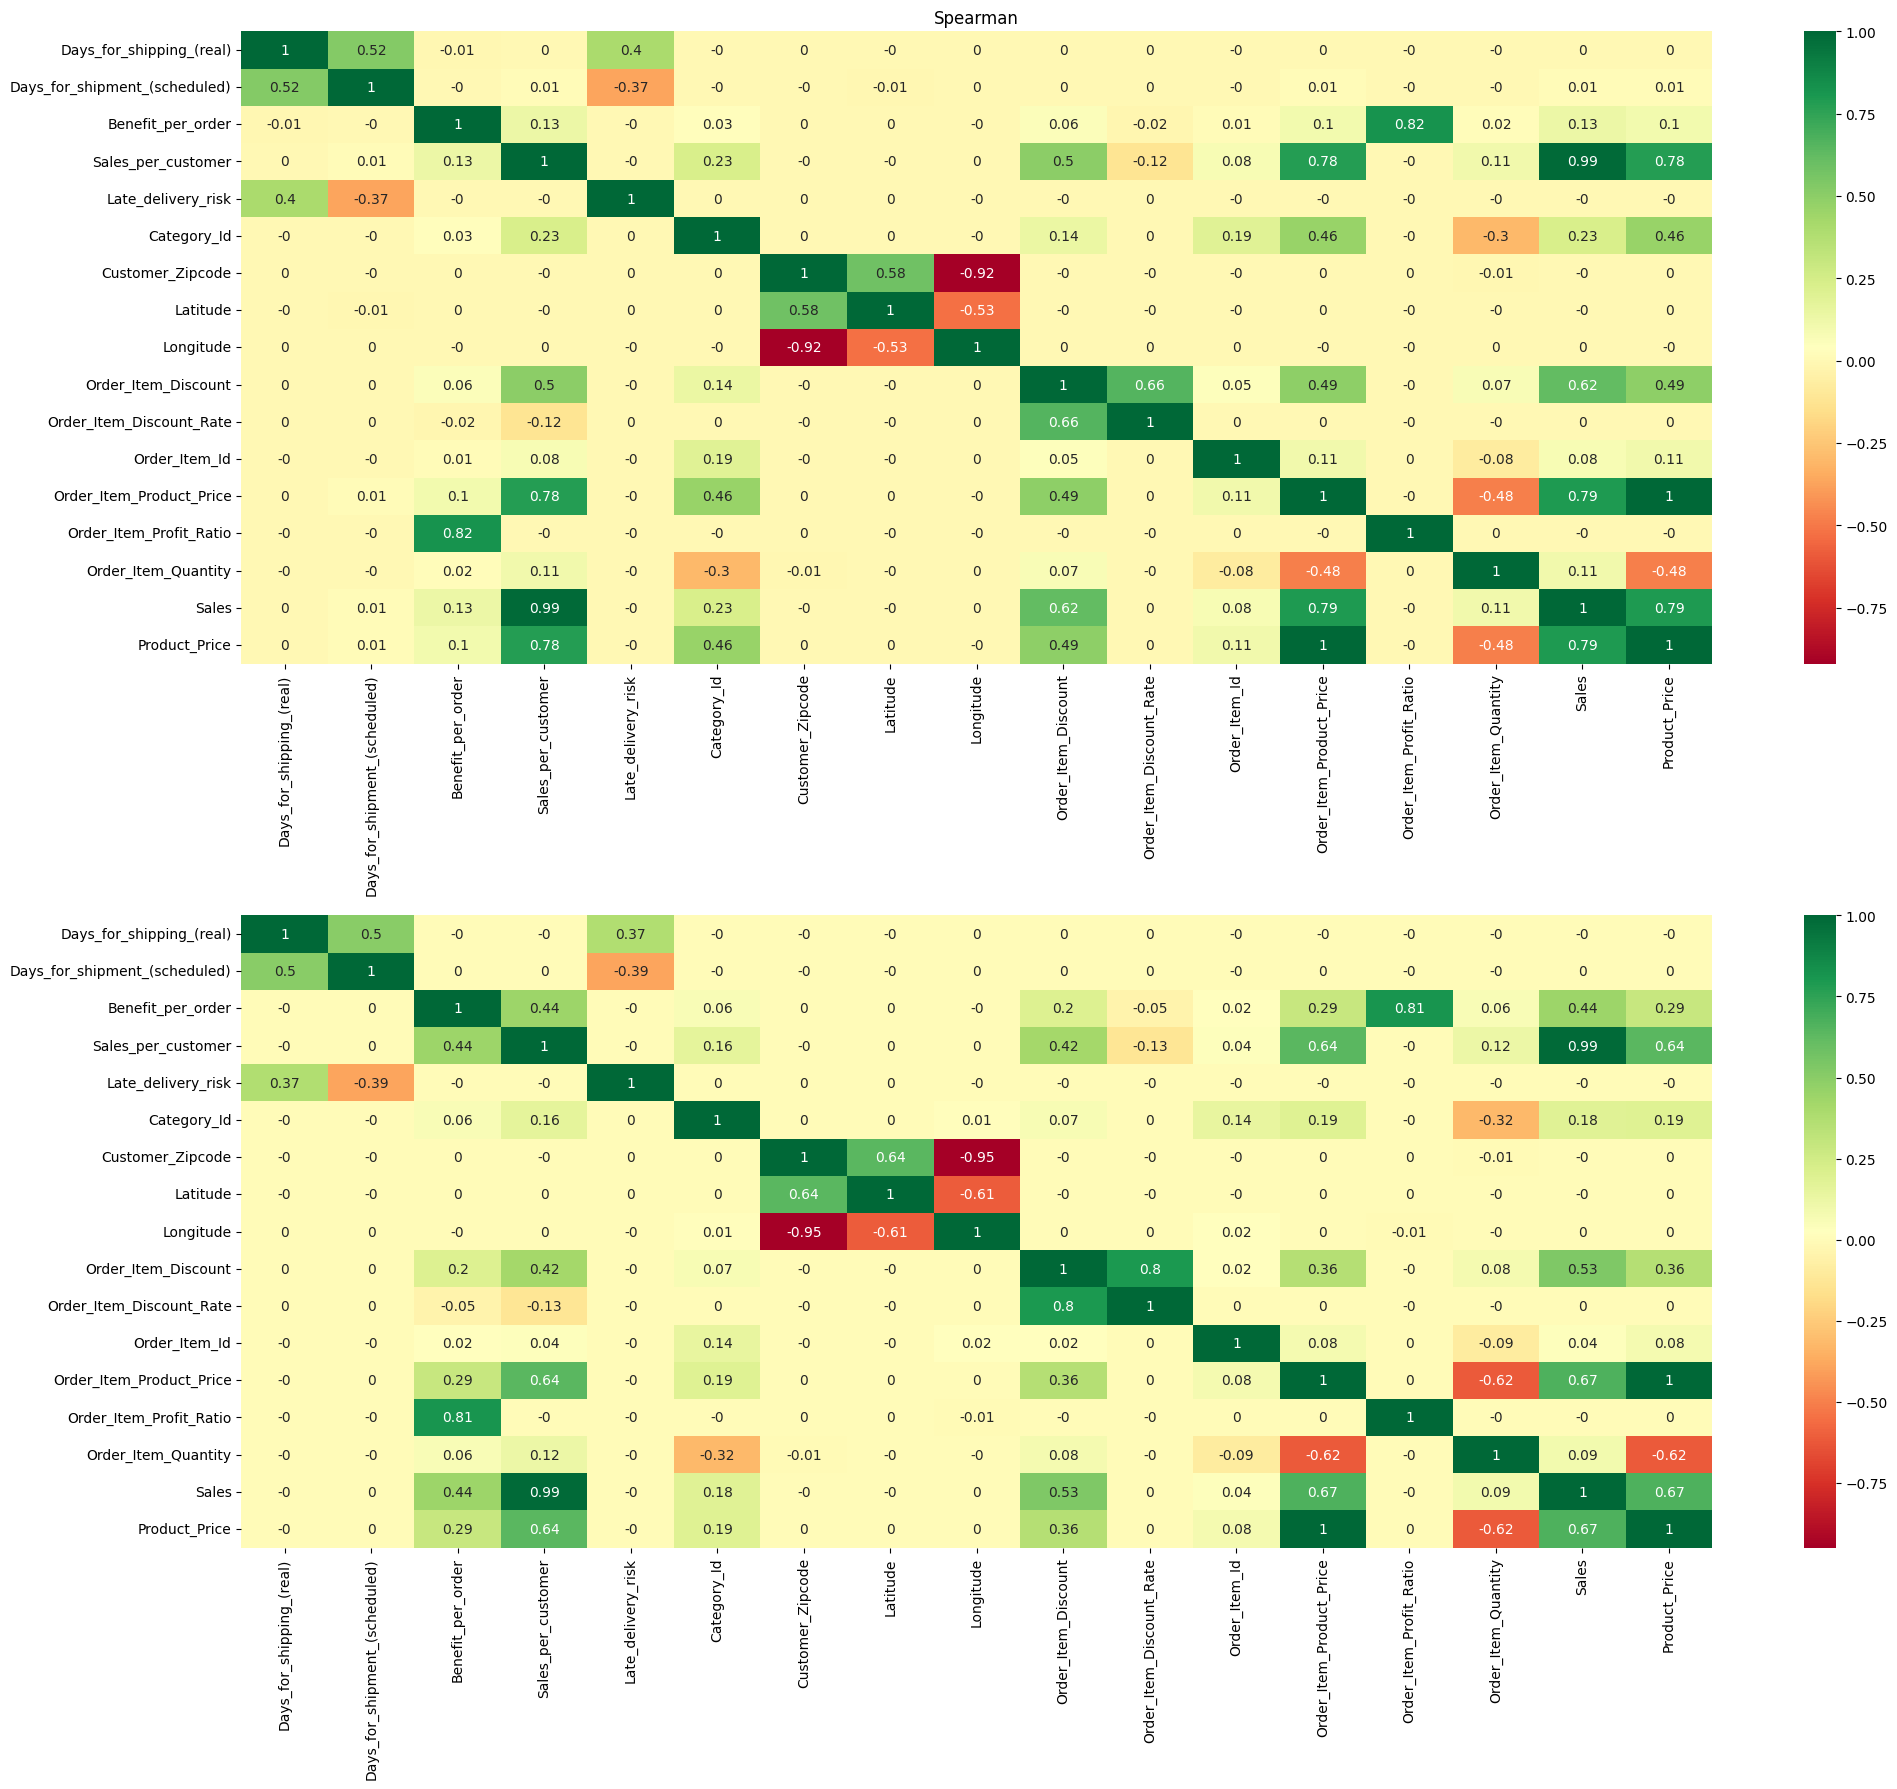

In [922]:
# Create heatmap based on pearson and spearman correlation values

_, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (21, 18))

sns.heatmap(df[numerical_columns].corr().round(2), annot = True, ax = axes[0], cmap="RdYlGn")
sns.heatmap(df[numerical_columns].corr(method = 'spearman').round(2), annot = True, ax = axes[1], cmap="RdYlGn")
axes[0].set_title('Pearson')
axes[0].set_title('Spearman')
plt.tight_layout()
plt.show()

### Distribution of Shipment Disparity

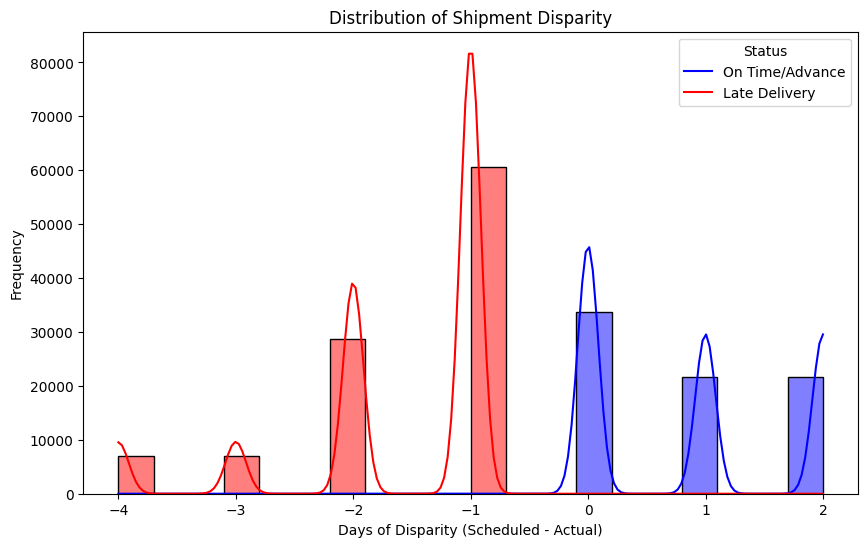

In [923]:
# Create a DataFrame
dd = pd.DataFrame()
dd['Shipment Disparity'] = df['Days_for_shipment_(scheduled)'] - df['Days_for_shipping_(real)']
dd['Status'] = dd['Shipment Disparity'] >= 0

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histogram with KDE and hue
sns.histplot(data=dd, x='Shipment Disparity', kde=True, hue='Status', palette={True: 'blue', False: 'red'}, bins=20)

# Add labels and title
plt.xlabel('Days of Disparity (Scheduled - Actual)')
plt.ylabel('Frequency')
plt.title('Distribution of Shipment Disparity')

# Add legend with descriptive labels
plt.legend(title='Status', labels=['On Time/Advance', 'Late Delivery'])

# Show the plot
plt.show()

#### Visual Cue from Histogram
- Late delivery includes -1, -2, and -3, with -1 representing the highest level of lateness, followed by -2 and -3. On-time deliveries or those ahead of schedule include 0, 1, and 2. In this categorization, -1 is the most delayed, while 0 indicates being exactly on time or slightly ahead. The levels decrease from -1 to -3 for late deliveries and increase from 0 to 2 for on-time deliveries.

### Density Plot of Benefit per Order

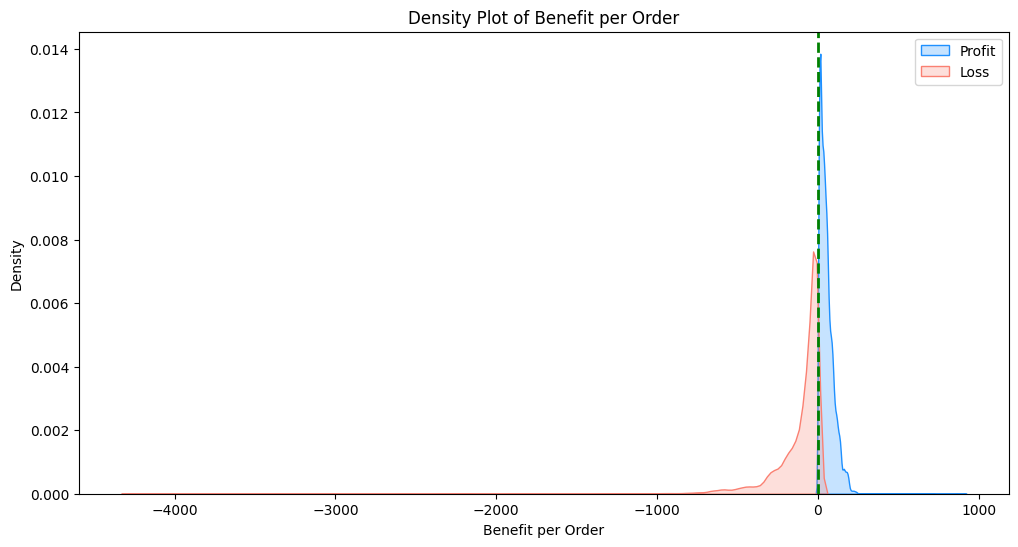

In [924]:
plt.figure(figsize=(12, 6))

# Filter data for profit and loss
profit_data = df[df['Benefit_per_order'] > 0]['Benefit_per_order']
loss_data = df[df['Benefit_per_order'] <= 0]['Benefit_per_order']

# Plot KDE for profit
sns.kdeplot(data=profit_data, color='dodgerblue', fill=True, label='Profit')

# Plot KDE for loss
sns.kdeplot(data=loss_data, color='salmon', fill=True, label='Loss')

# Add vertical line at zero
plt.axvline(0, color='green', linestyle='--', linewidth=2)

# Add legend, labels, and title
plt.legend()
plt.xlabel('Benefit per Order')
plt.ylabel('Density')
plt.title('Density Plot of Benefit per Order')

plt.show()

#### Visual Cue for KDE Plot
- In the KDE plot, the shorter tail for profit suggests that fewer instances have a higher benefit per order, with values almost reaching 1000. On the other hand, the longer tail for loss indicates that more instances experience greater losses, extending beyond 4000. The higher peak density for profit, nearly reaching 0.014, implies a concentration of data points around higher benefit values. The slightly lower maximum density for loss, just below 0.008, suggests a spread of data points across a wider range of loss values.

### Order Item Profit Ratio

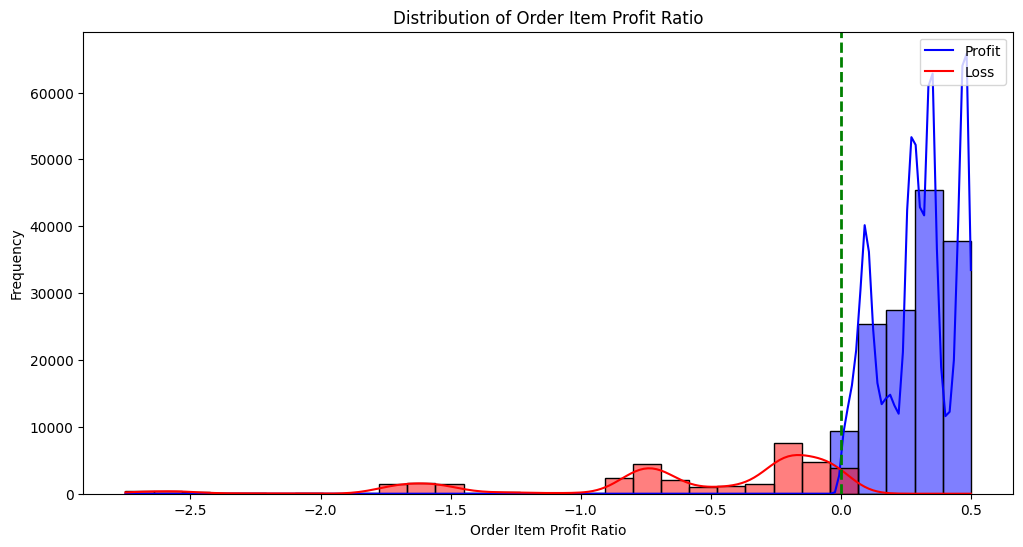

In [925]:
plt.figure(figsize=(12, 6))
plot = sns.histplot(data=df, x='Order_Item_Profit_Ratio', bins=30, kde=True, hue=df['Order_Item_Profit_Ratio'] > 0, palette=palette)
plt.xlabel('Order Item Profit Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Order Item Profit Ratio')
plot.legend(['Profit', 'Loss'], loc='upper right')
plt.axvline(0, color='green', linestyle='--', linewidth=2)
plt.show()

## Feature Engineering and Model Selection

In [926]:
# Create multiple features
df['order_year'] = pd.DatetimeIndex(df['order_date_(DateOrders)']).year
df['order_month'] = pd.DatetimeIndex(df['order_date_(DateOrders)']).month
df['order_day'] = pd.DatetimeIndex(df['order_date_(DateOrders)']).day
df['shipping_year'] = pd.DatetimeIndex(df['shipping_date_(DateOrders)']).year
df['shipping_month'] = pd.DatetimeIndex(df['shipping_date_(DateOrders)']).month
df['shipping_day'] = pd.DatetimeIndex(df['shipping_date_(DateOrders)']).day

In [927]:
# Drop the columns that were used for feature engineering
df.drop(columns = ['order_date_(DateOrders)', 'shipping_date_(DateOrders)', 'Category_Name'], inplace = True)
df.head()

,Type,Days_for_shipping_(real),Days_for_shipment_(scheduled),Benefit_per_order,Sales_per_customer,Delivery_Status,Late_delivery_risk,Category_Id,Customer_Segment,Customer_Zipcode,...,Order_State,Order_Status,Product_Price,Shipping_Mode,order_year,order_month,order_day,shipping_year,shipping_month,shipping_day
0,DEBIT,3,4,91.25,314.64,Advance shipping,0,73,Consumer,725,...,Java Occidental,COMPLETE,327.75,Standard Class,2018,1,31,2018,2,3
1,TRANSFER,5,4,-249.09,311.36,Late delivery,1,73,Consumer,725,...,Rajastan,PENDING,327.75,Standard Class,2018,1,13,2018,1,18
2,CASH,4,4,-247.78,309.72,Shipping on time,0,73,Consumer,95125,...,Rajastan,CLOSED,327.75,Standard Class,2018,1,13,2018,1,17
3,DEBIT,3,4,22.86,304.81,Advance shipping,0,73,Home Office,90027,...,Queensland,COMPLETE,327.75,Standard Class,2018,1,13,2018,1,16
4,PAYMENT,2,4,134.21,298.25,Advance shipping,0,73,Corporate,725,...,Queensland,PENDING_PAYMENT,327.75,Standard Class,2018,1,13,2018,1,15


In [928]:
def label_encode_columns(df, columns):
    for col in columns:
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])
        print(f"Encoded values and their corresponding categories for column '{col}':")
        for code, category in enumerate(label_encoder.classes_):
            print(f"{code}: {category}")
        print()
    
    return df

# List of columns to be label encoded
columns_to_encode = ['Type', 'Delivery_Status', 'Customer_Segment', 'Department_Name', 'Order_City', 
                     'Order_Country', 'Order_State', 'Order_Status', 'Shipping_Mode']  
df_encoded = label_encode_columns(df, columns_to_encode)

Encoded values and their corresponding categories for column 'Type':
0: CASH
1: DEBIT
2: PAYMENT
3: TRANSFER

Encoded values and their corresponding categories for column 'Delivery_Status':
0: Advance shipping
1: Late delivery
2: Shipping canceled
3: Shipping on time

Encoded values and their corresponding categories for column 'Customer_Segment':
0: Consumer
1: Corporate
2: Home Office

Encoded values and their corresponding categories for column 'Department_Name':
0: Apparel
1: Book Shop
2: Discs Shop
3: Fan Shop
4: Fitness
5: Footwear
6: Golf
7: Health and Beauty 
8: Outdoors
9: Pet Shop
10: Technology

Encoded values and their corresponding categories for column 'Order_City':
0: Aachen
1: Aalen
2: Aalst
3: Aba
4: Abadan
5: Abakaliki
6: Abbeville
7: Abbotsford
8: Abeokuta
9: Aberdeen
10: Abha
11: Abidjan
12: Abilene
13: Abreu e Lima
14: Abu Kabir
15: Acambaro
16: Acarigua
17: Acayucan
18: Accra
19: Acerra
20: Acireale
21: Acu
22: Acuna
23: Ad Diwaniyah
24: Ad Diwem
25: Adana
26: Ade

In [929]:
df_encoded.head()

,Type,Days_for_shipping_(real),Days_for_shipment_(scheduled),Benefit_per_order,Sales_per_customer,Delivery_Status,Late_delivery_risk,Category_Id,Customer_Segment,Customer_Zipcode,...,Order_State,Order_Status,Product_Price,Shipping_Mode,order_year,order_month,order_day,shipping_year,shipping_month,shipping_day
0,1,3,4,91.25,314.64,0,0,73,0,725,...,476,2,327.75,3,2018,1,31,2018,2,3
1,3,5,4,-249.09,311.36,1,1,73,0,725,...,841,5,327.75,3,2018,1,13,2018,1,18
2,0,4,4,-247.78,309.72,3,0,73,0,95125,...,841,1,327.75,3,2018,1,13,2018,1,17
3,1,3,4,22.86,304.81,0,0,73,2,90027,...,835,2,327.75,3,2018,1,13,2018,1,16
4,2,2,4,134.21,298.25,0,0,73,1,725,...,835,6,327.75,3,2018,1,13,2018,1,15


### Model Selection and Evaluation

In [930]:
# Create dependent and independent variables
X = df_encoded.drop(['Late_delivery_risk'], axis=1)
y = df_encoded['Late_delivery_risk']

# Train & test split for days for shipping (real) column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.50)

# Initialize logistic regression, decision tree and random forest classifier
log_reg = LogisticRegression()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

In [931]:
# Function
models = [log_reg, decision_tree, random_forest]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']
for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")
    print("\n")

Model: Logistic Regression
Accuracy: 0.55
Precision: 0.55
Recall: 0.96
F1-score: 0.70
ROC-AUC: 0.51


Model: Decision Tree
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00
ROC-AUC: 1.00


Model: Random Forest
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00
ROC-AUC: 1.00




In [932]:
# Peform cross-validation for each model
for model, name in zip(models, model_names):
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation scores for {name}: {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.2f}")
    print("\n")

Cross-validation scores for Logistic Regression: [0.55140705 0.54841569 0.54764015 0.54600853 0.54883386]
Mean CV accuracy: 0.55


Cross-validation scores for Decision Tree: [1. 1. 1. 1. 1.]
Mean CV accuracy: 1.00


Cross-validation scores for Random Forest: [1. 1. 1. 1. 1.]
Mean CV accuracy: 1.00




## Detailed Analysis

### What is the distribution of delivery times across different shipping modes?

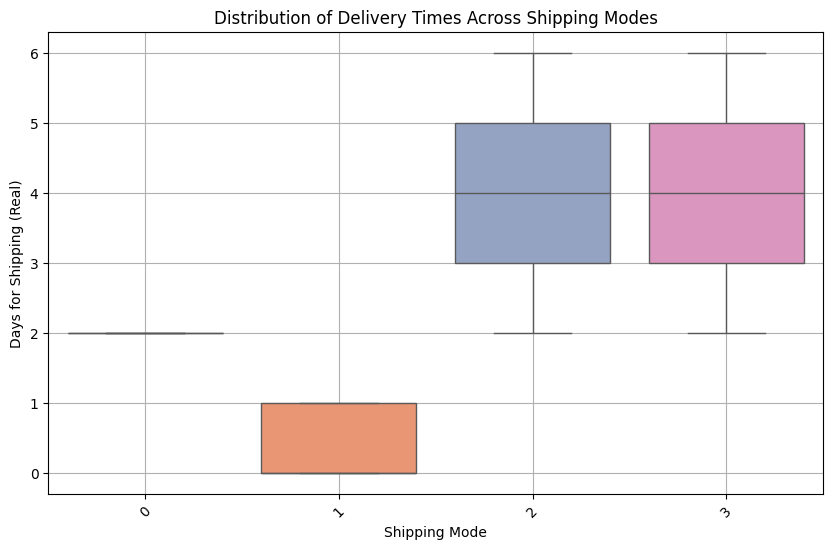

                  count  mean  std  min  25%  50%  75%  max
Shipping_Mode                                              
0              27813.00  2.00 0.00 2.00 2.00 2.00 2.00 2.00
1               9737.00  0.48 0.50 0.00 0.00 0.00 1.00 1.00
2              35216.00  3.99 1.42 2.00 3.00 4.00 5.00 6.00
3             107750.00  4.00 1.42 2.00 3.00 4.00 5.00 6.00


In [933]:
# Filter relevant columns
delivery_data = df[['Shipping_Mode', 'Days_for_shipping_(real)']]

# Group data by shipping mode
grouped_data = delivery_data.groupby('Shipping_Mode')

# Calculate summary statistics
summary_stats = grouped_data['Days_for_shipping_(real)'].describe()

# Visualize distribution of delivery times for each shipping mode
plt.figure(figsize=(10, 6))
sns.boxplot(x='Shipping_Mode', y='Days_for_shipping_(real)', data=delivery_data, palette='Set2')
plt.title('Distribution of Delivery Times Across Shipping Modes')
plt.xlabel('Shipping Mode')
plt.ylabel('Days for Shipping (Real)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Display summary statistics
print(summary_stats)

- Advance Shipping (0): All orders with advance shipping have an exact shipping time of 2 days.
- Late Delivery (1): Orders with late delivery have a mean shipping time of approximately 0.48 days, with a standard deviation of about 0.50 days. This indicates that late deliveries typically occur within a short timeframe after the scheduled delivery date.
- Shipping Canceled (2): Orders with canceled shipping have a mean scheduled delivery time of approximately 3.99 days, with a standard deviation of about 1.42 days. This suggests that orders with canceled shipping tend to have longer scheduled delivery times compared to other shipping modes.
- Shipping on Time (3): Orders shipped on time have a mean scheduled delivery time of approximately 3.99 days, with a standard deviation of about 1.42 days. This is consistent with the scheduled delivery times for orders with canceled shipping.

### Are there any trends or patterns in late deliveries based on the time of year or season?

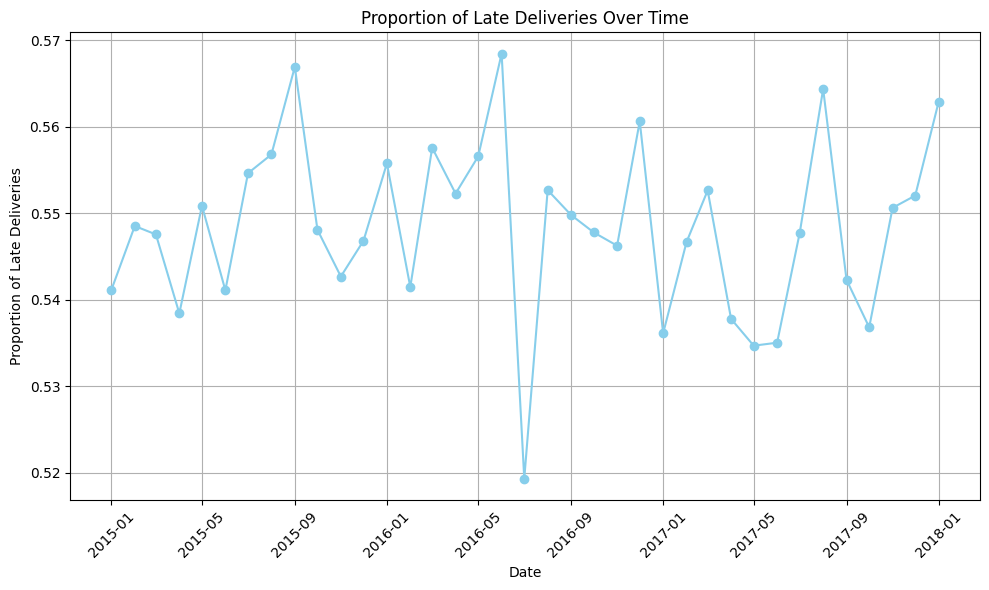

In [934]:
# Group data by year and month and calculate the proportion of late deliveries
monthly_late_deliveries = df.groupby(['order_year', 'order_month'])['Late_delivery_risk'].mean()

# Reset index to make plotting easier
monthly_late_deliveries = monthly_late_deliveries.reset_index()

# Combine year and month into a single column
monthly_late_deliveries['Date'] = monthly_late_deliveries['order_year'].astype(str) + '-' + monthly_late_deliveries['order_month'].astype(str)

# Convert to datetime format
monthly_late_deliveries['Date'] = pd.to_datetime(monthly_late_deliveries['Date'], format='%Y-%m')

# Sort values by date
monthly_late_deliveries.sort_values('Date', inplace=True)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(monthly_late_deliveries['Date'], monthly_late_deliveries['Late_delivery_risk'], marker='o', color='skyblue')
plt.title('Proportion of Late Deliveries Over Time')
plt.xlabel('Date')
plt.ylabel('Proportion of Late Deliveries')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Can we identify any geographical regions with consistently higher rates of late deliveries?

In [935]:
# Grouping the data by customer_zipcode and calculating the mean late delivery rate
zipcode_late_delivery_rates = df_encoded.groupby('Customer_Zipcode')['Late_delivery_risk'].mean()

# Sorting the results to identify clusters with consistently higher rates of late deliveries
zipcode_late_delivery_rates_sorted = zipcode_late_delivery_rates.sort_values(ascending=False)

# Displaying the clusters with consistently higher rates of late deliveries
print(zipcode_late_delivery_rates_sorted.head(20))

Customer_Zipcode
30034   0.93
11224   0.87
75040   0.85
90019   0.84
60644   0.82
76201   0.81
23464   0.81
10457   0.81
43302   0.79
11355   0.79
44256   0.79
98390   0.79
48066   0.77
2151    0.77
89115   0.76
92404   0.76
60505   0.76
30058   0.75
28540   0.75
91766   0.74
Name: Late_delivery_risk, dtype: float64


-Customer zipcode 30034 has a mean late delivery risk of 0.93, indicating that approximately 93% of orders from this zip code are at risk of being delivered late. Customer zipcode 11224 has a mean late delivery risk of 0.87, meaning that around 87% of orders from this zip code are at risk of late delivery. Similarly, for the other zip codes in the list, the mean late delivery risks range from approximately 85% to 75%.

### How does customer segmentation affect the likelihood of late deliveries?

Customer_Segment
NaN   0.55
NaN   0.55
NaN   0.55
Name: Late_delivery_risk, dtype: float64


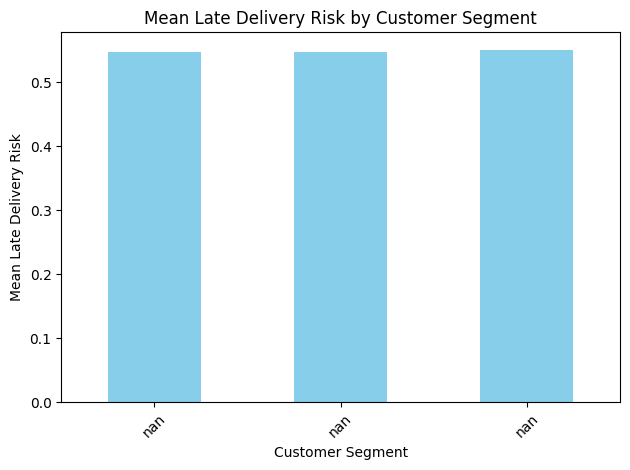

In [936]:
# Dictionary mapping encoded values to original categories for customer segment
segment_map = {0: 'Consumer', 1: 'Corporate', 2: 'Home Office'}

# Replace encoded values with corresponding segment names
customer_segment_mean_ldr.index = customer_segment_mean_ldr.index.map(segment_map)

# Displaying the mean late delivery risk for each customer segment with segment names
print(customer_segment_mean_ldr)

# Create figure and axis objects
fig, ax = plt.subplots()

# Plotting the bar chart
customer_segment_mean_ldr.plot(kind='bar', ax=ax, color='skyblue')

# Adding titles and labels
plt.title('Mean Late Delivery Risk by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Mean Late Delivery Risk')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

- The analysis reveals that across all customer segments, the mean late delivery risk hovers around 55%, indicating that no particular customer segment exhibits a significantly higher or lower likelihood of experiencing late deliveries.

### Is there a correlation between product category and late delivery risk?

Category_Id
34   0.69
5    0.60
72   0.59
62   0.58
10   0.58
16   0.57
71   0.57
40   0.57
11   0.57
59   0.57
76   0.56
37   0.56
12   0.56
35   0.56
44   0.56
66   0.56
69   0.56
6    0.56
68   0.56
41   0.56
13   0.56
33   0.56
73   0.55
26   0.55
4    0.55
3    0.55
29   0.55
65   0.55
74   0.55
17   0.55
45   0.55
48   0.55
46   0.55
36   0.55
24   0.55
43   0.55
9    0.54
18   0.54
75   0.54
2    0.54
70   0.54
67   0.54
31   0.54
7    0.54
63   0.53
38   0.53
60   0.53
61   0.52
32   0.52
64   0.51
30   0.48
Name: Late_delivery_risk, dtype: float64


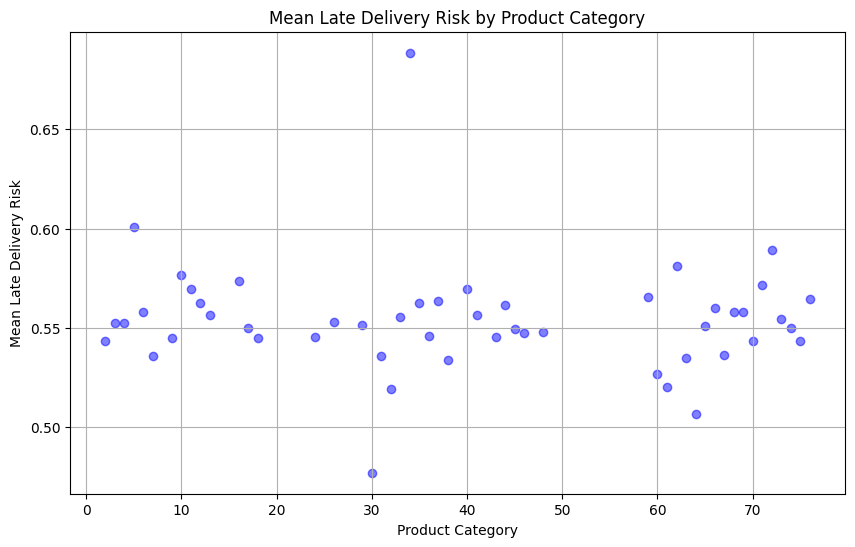

In [937]:
# Grouping the data by product category and calculating the mean late delivery risk
product_category_mean_ldr = df_encoded.groupby('Category_Id')['Late_delivery_risk'].mean()

# Sorting the values in descending order
product_category_mean_ldr = product_category_mean_ldr.sort_values(ascending=False)

# Displaying the mean late delivery risk for each product category
print(product_category_mean_ldr)

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(product_category_mean_ldr.index, product_category_mean_ldr.values, color='blue', alpha=0.5)
plt.title('Mean Late Delivery Risk by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Mean Late Delivery Risk')
plt.grid(True)
plt.show()

- Looking at the mean late delivery risk values for each product category, category 34 stands out the most with a mean late delivery risk of approximately 0.69. This suggests that products in category 34 are associated with a higher risk of late deliveries compared to other categories. Additionally, categories 5, 72, and 62 also have relatively high mean late delivery risks, ranging from approximately 0.58 to 0.60. On the other hand, categories with lower mean late delivery risks, such as category 30, have values around 0.48, indicating a lower likelihood of late deliveries for products in these categories.

### What impact does order value have on the probability of late deliveries?

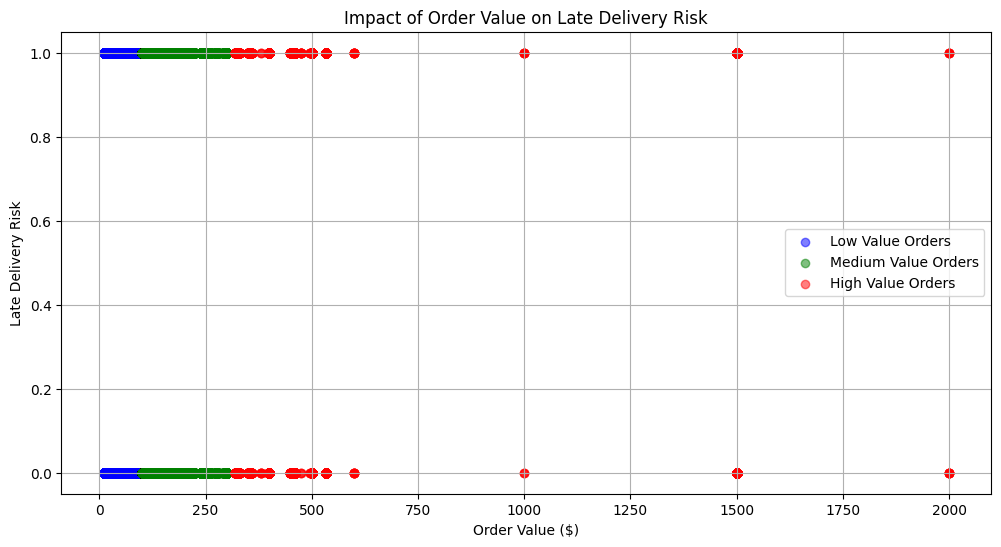

In [938]:

# Define the ranges for order values
low_value_range = df_encoded[df_encoded['Sales'] < 100]
medium_value_range = df_encoded[(df_encoded['Sales'] >= 100) & (df_encoded['Sales'] <= 300)]
high_value_range = df_encoded[df_encoded['Sales'] > 300]

# Plotting the distribution of order values and their relationship with the probability of late deliveries
plt.figure(figsize=(12, 6))

plt.scatter(low_value_range['Sales'], low_value_range['Late_delivery_risk'], color='blue', alpha=0.5, label='Low Value Orders')
plt.scatter(medium_value_range['Sales'], medium_value_range['Late_delivery_risk'], color='green', alpha=0.5, label='Medium Value Orders')
plt.scatter(high_value_range['Sales'], high_value_range['Late_delivery_risk'], color='red', alpha=0.5, label='High Value Orders')

plt.title('Impact of Order Value on Late Delivery Risk')
plt.xlabel('Order Value ($)')
plt.ylabel('Late Delivery Risk')
plt.legend()
plt.grid(True)
plt.show()


- Based on the scatter plot, there doesn't appear to be a clear correlation between order value and the probability of late deliveries across the defined ranges. This suggests that order value alone may not be a significant predictor of late deliveries, and other factors may influence delivery timeliness

### Are there any noticeable trends in late deliveries over time, such as improving or worsening performance?

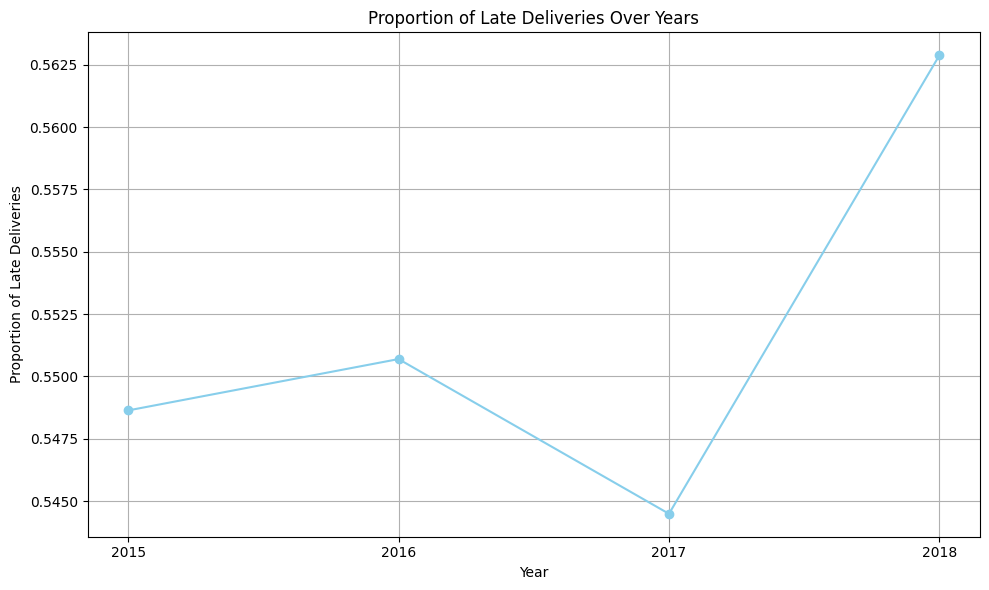

In [939]:
# Group data by year and calculate the proportion of late deliveries
yearly_late_deliveries = df_encoded.groupby('order_year')['Late_delivery_risk'].mean()

# Reset index to make plotting easier
yearly_late_deliveries = yearly_late_deliveries.reset_index()

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(yearly_late_deliveries['order_year'], yearly_late_deliveries['Late_delivery_risk'], marker='o', color='skyblue')
plt.title('Proportion of Late Deliveries Over Years')
plt.xlabel('Year')
plt.ylabel('Proportion of Late Deliveries')
plt.xticks(yearly_late_deliveries['order_year'])  # Set x-axis ticks to the years
plt.grid(True)
plt.tight_layout()
plt.show()


- In 2015, the proportion of late deliveries was approximately 54.86%. In 2016, the proportion of late deliveries increased slightly to around 55.07%. In 2017, there was a slight decrease in the proportion of late deliveries to about 54.45%.
In 2018, there was a big increase in the proportion of late deliveries to approximately 56.29%.

### Can we identify any specific regions associated with higher rates of late deliveries?

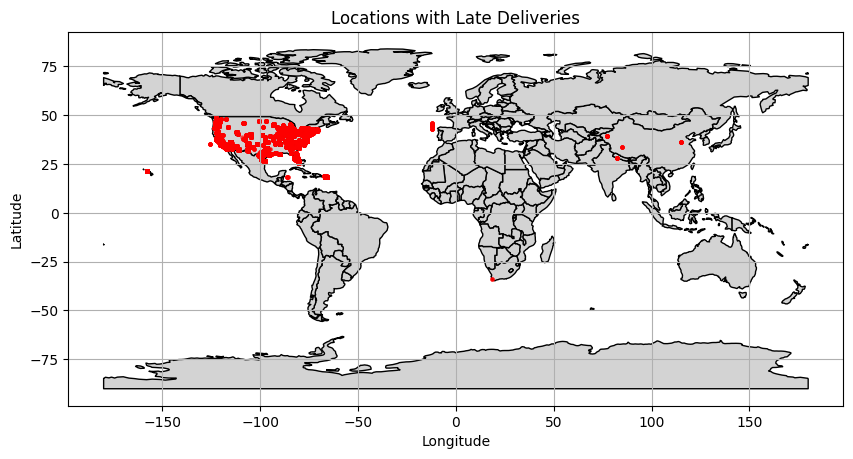

In [940]:
# Create a GeoDataFrame from the DataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']))

# Filter the GeoDataFrame to include only late deliveries
late_deliveries_gdf = gdf[gdf['Late_delivery_risk'] == 1]

# Plotting the map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 6), color='lightgrey', edgecolor='black')

# Plotting the data points with color-coded late delivery risk
late_deliveries_gdf.plot(ax=ax, marker='o', color='red', markersize=5, alpha=0.5)

# Customizing the plot
plt.title('Locations with Late Deliveries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

- Upon visualizing the geographical distribution of late delivery risk, it becomes apparent that the majority of late deliveries are concentrated within the United States. Conversely, there is minimal evidence of significant delivery risk occurring outside the US borders. 

### Is there a correlation between total sales and late delivery risk by department?

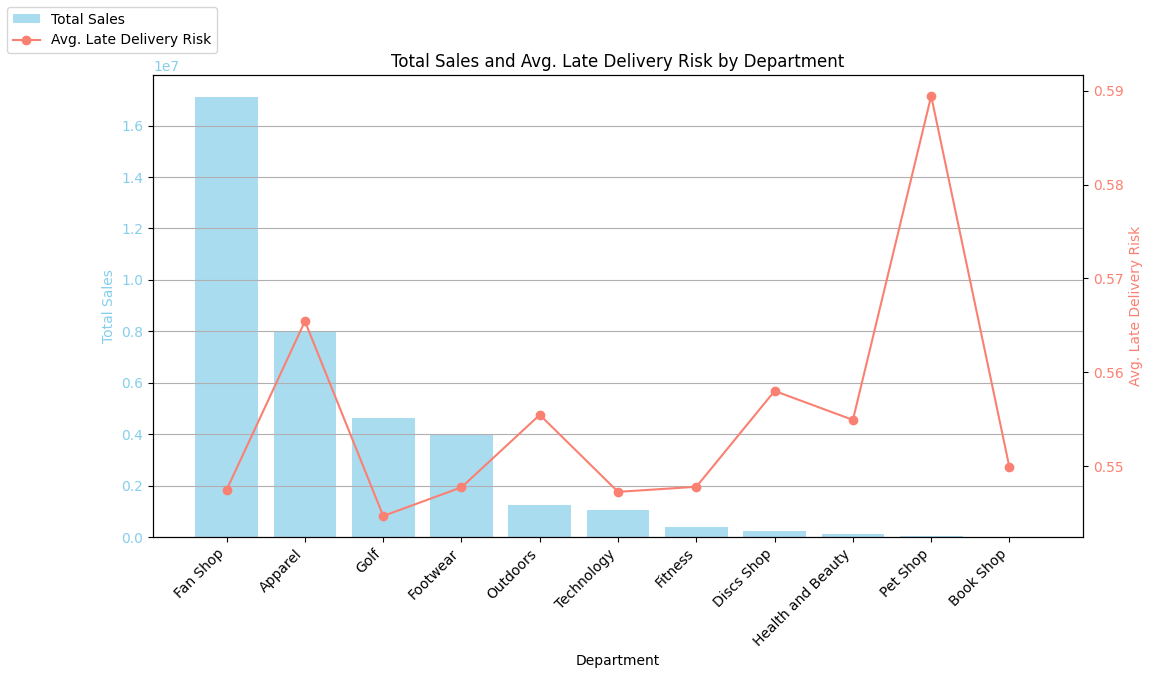

In [941]:
# Grouping the data by department and calculating the sum of sales and average late delivery risk
department_sales_late_delivery_risk = df_encoded.groupby('Department_Name').agg({
    'Sales': 'sum',
    'Late_delivery_risk': 'mean'
})

# Renaming columns for clarity
department_sales_late_delivery_risk.rename(columns={'Sales': 'Total Sales', 'Late_delivery_risk': 'Avg. Late Delivery Risk'}, inplace=True)

# Plotting the bar plot for department sales with corrected average late delivery risk
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot total sales
color = 'skyblue'
ax1.bar(range(len(department_sales)), department_sales, color=color, alpha=0.7, label='Total Sales')
ax1.set_xlabel('Department')
ax1.set_ylabel('Total Sales', color=color)
ax1.set_xticks(range(len(department_sales)))
ax1.set_xticklabels([department_names[i] for i in department_sales.index], rotation=45, ha='right')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(axis='y')

# Create a second y-axis for late delivery risk
ax2 = ax1.twinx()
color = 'salmon'
ax2.plot(range(len(department_sales_late_delivery_risk)), department_sales_late_delivery_risk['Avg. Late Delivery Risk'].values, marker='o', color=color, label='Avg. Late Delivery Risk')
ax2.set_ylabel('Avg. Late Delivery Risk', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show legend
fig.legend(loc='upper left')

plt.title('Total Sales and Avg. Late Delivery Risk by Department')
plt.show()

- Department 9 (Pet Shop) has the highest average late delivery risk at 0.59, despite having relatively low total sales of $41,524.80. Department 1 (Book Shop) has notably low total sales of $12,587.40 and a high average late delivery risk of 0.57. Department 0 (Apparel) stands out with 2nd highest  total sales of $7,975,898.24 and a relatively high average late delivery risk of 0.55, indicating that a significant portion of its sales is impacted by late delivery issues.

### How does the frequency of promotions or discounts affect delivery performance and customer satisfaction?

In [942]:
# Identify orders with discounts/promotions
df_encoded['Has_Discount'] = (df_encoded['Order_Item_Discount'] > 0) | (df_encoded['Order_Item_Discount_Rate'] > 0)

# Group the data by Has_Discount and calculate total sales and average late delivery risk
discount_performance = df_encoded.groupby('Has_Discount').agg({
    'Sales': 'sum',
    'Late_delivery_risk': 'mean'
})

# Rename columns for clarity
discount_performance.rename(columns={'Sales': 'Total Sales', 'Late_delivery_risk': 'Avg. Late Delivery Risk'}, inplace=True)

# Display the performance comparison
print(discount_performance)

              Total Sales  Avg. Late Delivery Risk
Has_Discount                                      
False          2042369.18                     0.56
True          34741716.10                     0.55


- Orders with discounts/promotions have significantly higher total sales compared to orders without discounts/promotions. Surprisingly, orders with discounts/promotions have a slightly lower average late delivery risk compared to orders without discounts/promotions. This suggests that while discounts/promotions drive higher sales volume, they may not necessarily increase the risk of late deliveries. 